In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functions_NLM import estimate_nested_logit, simulate_choice
from functions_NLM import multivariate_lognormal_pdf, largest_cluster_size

In [57]:
# Define log-likelihood function for telephone data
# beta will be beta = ["ASC_1", "ASC_3", "ASC_4", "ASC_5", "BETA_COST"]

# DEFINE MODEL STRUCTURE AND LIKELIHOOD FUNCTION
def log_likelihood_telephone_LM(beta, data):
    # Define utility functions
    data['U_1'] = beta[0] + beta[4] * data['logcost1'] 
    data['U_2'] = beta[4] * data['logcost2'] 
    data['U_3'] = beta[1] + beta[4] * data['logcost3']
    data['U_4'] = beta[2] + beta[4] * data['logcost4']
    data['U_5'] = beta[3] + beta[4] * data['logcost5']

    sum_total = np.exp(data['U_1']) * data['avail1'] + np.exp(data['U_2']) * data['avail2'] + \
                np.exp(data['U_3']) * data['avail3'] + np.exp(data['U_4']) * data['avail4'] + \
                np.exp(data['U_5']) * data['avail5']
    
    # Full probabilities
    data['P_1'] = np.exp(data['U_1']) * data['avail1'] / sum_total
    data['P_2'] = np.exp(data['U_2']) * data['avail2'] / sum_total
    data['P_3'] = np.exp(data['U_3']) * data['avail3'] / sum_total
    data['P_4'] = np.exp(data['U_4']) * data['avail4'] / sum_total
    data['P_5'] = np.exp(data['U_5']) * data['avail5'] / sum_total
    
    # Calculate probability for chosen alternative for each row
    data['P'] = (data['choice'] == 1) * data['P_1'] + \
                (data['choice'] == 2) * data['P_2'] + \
                (data['choice'] == 3) * data['P_3'] + \
                (data['choice'] == 4) * data['P_4'] + \
                (data['choice'] == 5) * data['P_5']
    
    # Replace zero probabilities with small value to avoid LL = -inf
    epsilon = 1e-20
    data.loc[data['P'] == 0, 'P'] = epsilon
    
    # Calculate log-likelihood 
    LL = data['P'].apply(np.log).sum()
    
    return -LL  # We minimize negative log-likelihood

In [58]:
# Load data
data = pd.read_csv('./data/telephone.dat', sep='\t')

data['logcost1'] = np.log(data['cost1'])
data['logcost2'] = np.log(data['cost2'])
data['logcost3'] = np.log(data['cost3'])
data['logcost4'] = np.log(data['cost4'])
data['logcost5'] = np.log(data['cost5'])

# Define model parameters
beta = np.array([0, 0, 0, 0, 0])

beta_names = ["ASC_1", "ASC_3", "ASC_4", "ASC_5", "BETA_COST"]


In [59]:
# Estimate parameters
result, se, t_stat, p_value, aic, bic  = estimate_nested_logit(data, beta, beta_names, log_likelihood_telephone_LM)

Optimization Results:
   Parameter  Estimate  Robust Asymptotic SE  t-statistic       p-value
0      ASC_1 -0.721243              0.153463    -4.699777  3.514203e-06
1      ASC_3  1.201266              0.154843     7.757947  6.372680e-14
2      ASC_4  0.999199              0.702369     1.422612  1.555754e-01
3      ASC_5  1.736400              0.275862     6.294454  7.631404e-10
4  BETA_COST -2.026204              0.213538    -9.488723  0.000000e+00
AIC: 965.1137706159915
BIC: 985.4789932864935
Log-likelihood: -477.55688530799574


In [60]:
from functions_geom_DIB import geom_DIB_on_alternatives

<h2> We need to change the way we handle missing values for alternative 4 and 5. We take the mean vector by removing the missing values. </h2>

In [61]:
df_logcost = data[['logcost1', 'logcost2', 'logcost3', 'logcost4', 'logcost5']]

# Compute the mean vector and covariance matrix
log_df_logcost = np.log(df_logcost)
mean_vector = log_df_logcost.mean()

#covariance_matrix = log_df_logcost.cov()

# # Compute the mean for alternative 4 and 5 by removing missing values
true_alt_4 = log_df_logcost['logcost4'] * data['avail4']
true_alt_5 = log_df_logcost['logcost5'] * data['avail5']
true_alt_4 = true_alt_4[true_alt_4 != 0]
true_alt_5 = true_alt_5[true_alt_5 != 0]
mean_vector[3] = true_alt_4.mean()
mean_vector[4] = true_alt_5.mean()

# # Compute diagonal covariance matrix 
var1 = log_df_logcost['logcost1'].var()
var2 = log_df_logcost['logcost2'].var()
var3 = log_df_logcost['logcost3'].var()
var4 = true_alt_4.var()
var5 = true_alt_5.var()

cov12 = log_df_logcost['logcost1'].cov(log_df_logcost['logcost2'])
cov13 = log_df_logcost['logcost1'].cov(log_df_logcost['logcost3'])
cov14 = log_df_logcost['logcost1'].cov(true_alt_4)
cov15 = log_df_logcost['logcost1'].cov(true_alt_5)
cov23 = log_df_logcost['logcost2'].cov(log_df_logcost['logcost3'])
cov24 = log_df_logcost['logcost2'].cov(true_alt_4)
cov25 = log_df_logcost['logcost2'].cov(true_alt_5)
cov34 = log_df_logcost['logcost3'].cov(true_alt_4)
cov35 = log_df_logcost['logcost3'].cov(true_alt_5)
cov45 = true_alt_4.cov(true_alt_5)


covariance_matrix = np.array([[var1, cov12, cov13, cov14, cov15],
                              [cov12, var2, cov23, cov24, cov25],
                              [cov13, cov23, var3, cov34, cov35],
                              [cov14, cov24, cov34, var4, cov45],
                              [cov15, cov25, cov35, cov45, var5]])

covariance_matrix_increased = covariance_matrix * 50

# Compute the probability density for each individual's cost vector
#df_logcost['probability_density'] = df_logcost.apply(lambda row: multivariate_lognormal_pdf(row.values, mean_vector, covariance_matrix_increased), axis=1)

/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_1010/3590536948.py:14: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  mean_vector[3] = true_alt_4.mean()
/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_1010/3590536948.py:15: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  mean_vector[4] = true_alt_5.mean()


In [62]:
covariance_matrix

array([[0.09575287, 0.06465456, 0.02918444, 0.13985829, 0.00038721],
       [0.06465456, 0.05388416, 0.02541997, 0.12646603, 0.00129328],
       [0.02918444, 0.02541997, 0.02392098, 0.11280802, 0.00043904],
       [0.13985829, 0.12646603, 0.11280802, 0.10919936, 0.        ],
       [0.00038721, 0.00129328, 0.00043904, 0.        , 0.00178899]])

In [63]:
np.linalg.det(covariance_matrix)

-8.37401991264689e-09

---
---
---
---
---

<h2> We simulate data </h2>

In [64]:
np.random.seed(123)
simulated_data_normal = np.random.multivariate_normal(mean_vector, covariance_matrix, size=1000)

simulated_data_lognormal = np.exp(simulated_data_normal)

/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_1010/544950392.py:2: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  simulated_data_normal = np.random.multivariate_normal(mean_vector, covariance_matrix, size=1000)


In [65]:
# make a dataframe from the simulated data
simulated_data_lognormal_df = pd.DataFrame(simulated_data_lognormal,
                                            columns=['logcost1', 'logcost2', 'logcost3',
                                                      'logcost4', 'logcost5'])


In [66]:
simulated_data_lognormal_df

,logcost1,logcost2,logcost3,logcost4,logcost5
0,2.976026,3.351868,3.290966,3.692054,3.291462
1,0.939522,0.944094,1.343215,2.742061,3.142592
2,2.764620,2.554737,2.272954,3.858228,3.276186
3,3.669772,2.857478,3.003880,2.048724,3.287595
4,1.720663,1.890323,3.130251,1.669781,3.071263
...,...,...,...,...,...
995,1.766546,1.473738,1.939625,2.183000,3.117454
996,2.046778,1.970739,2.184695,1.872620,3.168172
997,3.930724,3.133261,3.353708,4.573225,3.342469
998,2.501271,2.817009,4.444495,3.939180,3.125367


In [67]:
def multivariate_lognormal_integral(interval_bounds, mean, covariance_matrix, num_samples=50000):
    """
    Calculate the integral of the multivariate lognormal PDF over a chosen interval in five dimensions using Monte Carlo integration.

    Parameters:
        interval_bounds (list of tuples): List of tuples specifying the lower and upper bounds of the interval for each dimension.
        mean (array-like): Mean vector of the multivariate lognormal distribution.
        covariance_matrix (2D array-like): Covariance matrix of the multivariate lognormal distribution.
        num_samples (int): Number of samples to use in Monte Carlo integration. Default is 50000.

    Returns:
        float: Estimated value of the integral.
    """
    # Generate random samples within the specified interval
    samples = []
    for bounds in interval_bounds:
        lower_bound, upper_bound = bounds
        samples.append(np.random.uniform(lower_bound, upper_bound, num_samples))
    samples = np.array(samples).T
    
    # transform samples into a dataframe of 5 columns
    samples = pd.DataFrame(samples, columns=['logcost1', 'logcost2', 'logcost3', 'logcost4', 'logcost5'])

    # Calculate the PDF values for the each sample point
    pdf_values = samples.apply(lambda row: multivariate_lognormal_pdf(row.values,
                                                                       mean, covariance_matrix), axis=1)

    # Estimate the integral using Monte Carlo integration
    integral_estimate = np.mean(pdf_values)
    print(integral_estimate)
    interval_volume = np.prod([upper_bound - lower_bound for lower_bound, upper_bound in interval_bounds])
    integral_estimate *= interval_volume

    return integral_estimate

In [68]:
# Define intervals for each dimension
num_intervals = 2 # Number of intervals for each dimension
intervals = []
for i in range(len(mean_vector)):
    min_val = np.min(simulated_data_lognormal[:, i])
    min_val_integer = np.floor(min_val)
    max_val = np.max(simulated_data_lognormal[:, i])
    max_val_integer = np.ceil(max_val)
    interval_width = (max_val_integer - min_val_integer) / num_intervals
    interval_edges = np.linspace(min_val_integer, max_val_integer, num_intervals + 1)
    intervals.append(interval_edges)


In [69]:
intervals

[array([0., 3., 6.]),
 array([0. , 2.5, 5. ]),
 array([1. , 3.5, 6. ]),
 array([ 0.,  7., 14.]),
 array([2., 3., 4.])]

In [70]:
# Initialize dictionary to store results
integral_results = {}

# Calculate the mean and covariance matrix of the simulated data
log_sim_data = np.log(simulated_data_lognormal_df)
mean_simulated_data = log_sim_data.mean()
cov_simulated_data = log_sim_data.cov()
# artificially increase variance of logcost5
cov_simulated_data.loc['logcost5', 'logcost5'] = 10 * cov_simulated_data.loc['logcost5', 'logcost5']

# Iterate over the first n-1 values in each dimension
for i in range(len(intervals[0]) - 1):
    for j in range(len(intervals[1]) - 1):
        for k in range(len(intervals[2]) - 1):
            for l in range(len(intervals[3]) - 1):
                for m in range(len(intervals[4]) - 1):
                    # Calculate the difference between consecutive values in each dimension
                    diff_1 = intervals[0][i + 1] - intervals[0][i]
                    diff_2 = intervals[1][j + 1] - intervals[1][j]
                    diff_3 = intervals[2][k + 1] - intervals[2][k]
                    diff_4 = intervals[3][l + 1] - intervals[3][l]
                    diff_5 = intervals[4][m + 1] - intervals[4][m]
                    
                    # Define the interval bounds using the differences calculated
                    interval_bounds = [(intervals[0][i], intervals[0][i] + diff_1),
                                       (intervals[1][j], intervals[1][j] + diff_2),
                                       (intervals[2][k], intervals[2][k] + diff_3),
                                       (intervals[3][l], intervals[3][l] + diff_4),
                                       (intervals[4][m], intervals[4][m] + diff_5)]
                    
                    # Calculate the integral for the current interval bounds
                    integral_value = multivariate_lognormal_integral(interval_bounds,
                                                                      mean_simulated_data, cov_simulated_data,
                                                                      num_samples=20000)
                    # Store the integral value in the results dictionary
                    integral_results[tuple(interval_bounds)] = integral_value

# Print the integral value for each interval combination
for interval_bounds, integral_value in integral_results.items():
    print("Integral over interval bounds {}: {}".format(interval_bounds, integral_value))


4.287749805701398e-13
2.5149695518357386e-48
2.164002407939737e-56
3.7332489636800735e-87
1.8150224666232038e-41
2.3932683161873456e-78
1.1143008274628042e-94
3.138093461785766e-148
3.6958972322733406e-25
9.83524268683526e-60
2.0017326372896346e-59
3.8981445346766135e-94
8.558828033210872e-40
1.2762580315675235e-74
2.1540026945462595e-80
2.0761527698851328e-109
6.219384654732352e-28
1.2835639366255141e-64
3.318648688366416e-58
9.703667160234965e-92
2.8256892563666213e-59
1.7550619482127637e-95
1.1416784448791022e-105
1.0986112488542832e-153
8.978571637824118e-28
3.9140672046518574e-64
2.1826607359396735e-55
3.113772949313083e-89
4.1920913718608e-37
2.0042929531115693e-75
6.76421777548511e-63
8.638377412179914e-103
Integral over interval bounds ((0.0, 3.0), (0.0, 2.5), (1.0, 3.5), (0.0, 7.0), (2.0, 3.0)): 5.6276716199830844e-11
Integral over interval bounds ((0.0, 3.0), (0.0, 2.5), (1.0, 3.5), (0.0, 7.0), (3.0, 4.0)): 3.300897536784407e-46
Integral over interval bounds ((0.0, 3.0), (0.0

In [71]:
# Initialize an empty list to store the probabilities
probabilities = []

# Iterate over each datapoint
for datapoint in simulated_data_lognormal:
    # Initialize a variable to store the probability of the interval containing the datapoint
    probability = 0.0
    
    # Iterate over each interval in the integral results
    for interval_bounds, integral_value in integral_results.items():
        # Check if the datapoint falls within the interval
        if all(lower_bound <= value < upper_bound for (lower_bound, upper_bound), value in zip(interval_bounds, datapoint)):
            # If the datapoint is within the interval, assign the probability of that interval
            probability = integral_value
            break  # Exit the loop once the interval is found
    
    # Append the probability to the list of probabilities
    probabilities.append(probability)

# Add the list of probabilities as a new column to your DataFrame
simulated_data_lognormal_df['Probability'] = probabilities

In [72]:
simulated_data_lognormal_df

,logcost1,logcost2,logcost3,logcost4,logcost5,Probability
0,2.976026,3.351868,3.290966,3.692054,3.291462,1.290876e-57
1,0.939522,0.944094,1.343215,2.742061,3.142592,3.300898e-46
2,2.764620,2.554737,2.272954,3.858228,3.276186,1.290876e-57
3,3.669772,2.857478,3.003880,2.048724,3.287595,5.137213e-62
4,1.720663,1.890323,3.130251,1.669781,3.071263,3.300898e-46
...,...,...,...,...,...,...
995,1.766546,1.473738,1.939625,2.183000,3.117454,3.300898e-46
996,2.046778,1.970739,2.184695,1.872620,3.168172,3.300898e-46
997,3.930724,3.133261,3.353708,4.573225,3.342469,5.137213e-62
998,2.501271,2.817009,4.444495,3.939180,3.125367,1.675089e-72


---
---
---

<h2> Simulate utility using Gumbel distribution, then apply logit formula for the probabilities p(y|x) and then take the choice by the Evangelos procedure </h2>

<h3> We take the same theta as the ones that we found with the real data and we simulate choices by taking error terms as EV(0,1) </h3>

In [73]:
theta_calculated = result.x

In [74]:
# function to simulate a choice for a given individual 
def simulated_choice_from_logcosts(logcosts): 
    U_1 = theta_calculated[0] + theta_calculated[4] * logcosts.iloc[0] + np.random.gumbel()
    U_2 = theta_calculated[4] * logcosts.iloc[1] + np.random.gumbel()
    U_3 = theta_calculated[1] + theta_calculated[4] * logcosts.iloc[2] + np.random.gumbel()
    U_4 = theta_calculated[2] + theta_calculated[4] * logcosts.iloc[3] + np.random.gumbel()
    U_5 = theta_calculated[3] + theta_calculated[4] * logcosts.iloc[4] + np.random.gumbel()

    sum_total = np.exp(U_1) + np.exp(U_2) + np.exp(U_3) + np.exp(U_4) + np.exp(U_5)

    P_1 = np.exp(U_1) / sum_total
    P_2 = np.exp(U_2) / sum_total
    P_3 = np.exp(U_3) / sum_total
    P_4 = np.exp(U_4) / sum_total
    P_5 = np.exp(U_5) / sum_total

    probabilities_df = pd.DataFrame({'P_1': [P_1], 'P_2': [P_2], 'P_3': [P_3], 'P_4': [P_4], 'P_5': [P_5]})

    choice = simulate_choice(probabilities_df.iloc[0])

    return P_1, P_2, P_3, P_4, P_5, choice

In [75]:
# simulate a choice for each individual in the simulated data and keep probability of each choice in the dataset
simulated_data_lognormal_df[['P_1', 'P_2', 'P_3', 'P_4', 'P_5', 'simulated_choice']] = simulated_data_lognormal_df.apply(simulated_choice_from_logcosts, axis=1, result_type='expand')

In [76]:
simulated_data_lognormal_df

,logcost1,logcost2,logcost3,logcost4,logcost5,Probability,P_1,P_2,P_3,P_4,P_5,simulated_choice
0,2.976026,3.351868,3.290966,3.692054,3.291462,1.290876e-57,0.093061,0.047739,0.162076,0.401501,0.295623,4.0
1,0.939522,0.944094,1.343215,2.742061,3.142592,3.300898e-46,0.032693,0.542331,0.385451,0.015926,0.023599,2.0
2,2.764620,2.554737,2.272954,3.858228,3.276186,1.290876e-57,0.003886,0.036601,0.206551,0.003974,0.748989,5.0
3,3.669772,2.857478,3.003880,2.048724,3.287595,5.137213e-62,0.046765,0.022346,0.633103,0.270056,0.027730,4.0
4,1.720663,1.890323,3.130251,1.669781,3.071263,3.300898e-46,0.081952,0.104365,0.494838,0.289661,0.029185,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...
995,1.766546,1.473738,1.939625,2.183000,3.117454,3.300898e-46,0.029628,0.026813,0.808849,0.117810,0.016900,3.0
996,2.046778,1.970739,2.184695,1.872620,3.168172,3.300898e-46,0.035527,0.075383,0.078359,0.779686,0.031045,4.0
997,3.930724,3.133261,3.353708,4.573225,3.342469,5.137213e-62,0.082550,0.560624,0.038995,0.026797,0.291035,5.0
998,2.501271,2.817009,4.444495,3.939180,3.125367,1.675089e-72,0.891102,0.005097,0.000537,0.046721,0.056543,1.0


---
---
---
---
---

In [77]:
# Computation of p(x,y)
p_x = simulated_data_lognormal_df['Probability'].values
# Replace zero probabilities with small value
epsilon = 1e-300
p_x[p_x == 0] += epsilon

p_y_given_x = simulated_data_lognormal_df[['P_1', 'P_2', 'P_3', 'P_4', 'P_5']].values
p_xy = p_x[:, np.newaxis] * p_y_given_x

# Normalize p_xy 
p_xy /= p_xy.sum()

Iteration: 1 out of 5000
Iteration: 2 out of 5000
Iteration: 3 out of 5000
Iteration: 4 out of 5000
Iteration: 5 out of 5000
Iteration: 6 out of 5000
Iteration: 7 out of 5000
Iteration: 8 out of 5000
Iteration: 9 out of 5000
Iteration: 10 out of 5000
Iteration: 11 out of 5000
Iteration: 12 out of 5000
Iteration: 13 out of 5000
Iteration: 14 out of 5000
Iteration: 15 out of 5000
Iteration: 16 out of 5000
Iteration: 17 out of 5000
Iteration: 18 out of 5000
Iteration: 19 out of 5000
Iteration: 20 out of 5000
Iteration: 21 out of 5000
Iteration: 22 out of 5000
Iteration: 23 out of 5000
Iteration: 24 out of 5000
Iteration: 25 out of 5000
Iteration: 26 out of 5000
Iteration: 27 out of 5000
Iteration: 28 out of 5000
Iteration: 29 out of 5000
Iteration: 30 out of 5000
Iteration: 31 out of 5000
Iteration: 32 out of 5000
Iteration: 33 out of 5000
Iteration: 34 out of 5000
Iteration: 35 out of 5000
Iteration: 36 out of 5000
Iteration: 37 out of 5000
Iteration: 38 out of 5000
Iteration: 39 out of 

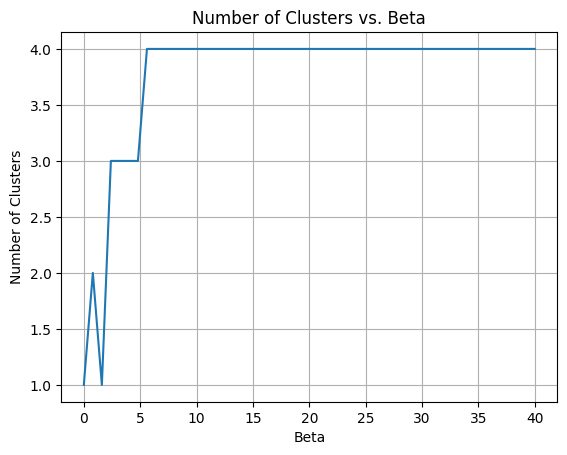

In [78]:
betas = np.linspace(0, 40, 51)
# Initialize an empty list to store the number of clusters
num_clusters_list = []
largest_cluster_sizes = []

# Iterate over each beta value
for beta in betas:
    # Run iterative_algorithm to obtain q_t_given_x
    q_t_given_x, _, _ = geom_DIB_on_alternatives(p_xy, max_iter=5000, beta=beta, threshold=1e-4)
    
    # Calculate the number of clusters
    column_sum = np.sum(q_t_given_x, axis=0)
    num_clusters = np.count_nonzero(column_sum)
    # Append the number of clusters to the list
    num_clusters_list.append(num_clusters)

        # Calculate the size of the largest cluster
    largest_size = largest_cluster_size(q_t_given_x)
    # Append the size of the largest cluster to the list
    largest_cluster_sizes.append(largest_size)

# Plot the number of clusters against beta values
plt.plot(betas, num_clusters_list)
plt.xlabel('Beta')
plt.ylabel('Number of Clusters')
plt.title('Number of Clusters vs. Beta')
plt.grid(True)
plt.show()

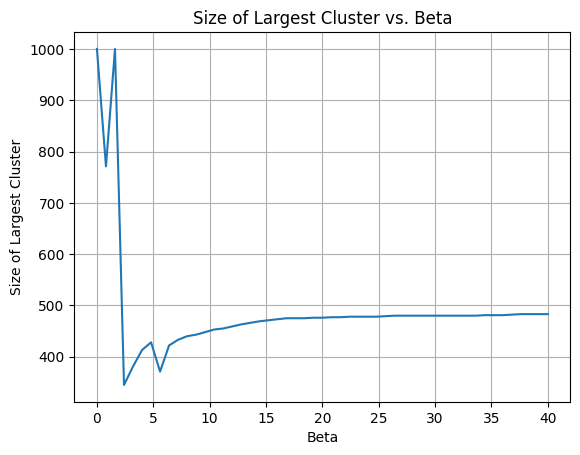

In [82]:
# Plot the number of elements in the largest cluster against beta values
plt.plot(betas, largest_cluster_sizes)
plt.xlabel('Beta')
plt.ylabel('Size of Largest Cluster')
plt.title('Size of Largest Cluster vs. Beta')
plt.grid(True)
plt.show()

In [80]:
q_t_given_x, q_t, q_y_given_t = geom_DIB_on_alternatives(p_xy, beta=40, max_iter=50000, threshold=1e-5)

Iteration: 1 out of 50000
Iteration: 2 out of 50000
Iteration: 3 out of 50000
Iteration: 4 out of 50000
Iteration: 5 out of 50000
Iteration: 6 out of 50000
Iteration: 7 out of 50000
Iteration: 8 out of 50000
Iteration: 9 out of 50000
Iteration: 10 out of 50000
Iteration: 11 out of 50000
Iteration: 12 out of 50000
Iteration: 13 out of 50000
Iteration: 14 out of 50000
Iteration: 15 out of 50000
Iteration: 16 out of 50000
Iteration: 17 out of 50000
Iteration: 18 out of 50000
Iteration: 19 out of 50000
Iteration: 20 out of 50000
Iteration: 21 out of 50000
Iteration: 22 out of 50000
Iteration: 23 out of 50000
Iteration: 24 out of 50000
Iteration: 25 out of 50000
Iteration: 26 out of 50000
Iteration: 27 out of 50000
Iteration: 28 out of 50000
Iteration: 29 out of 50000
Iteration: 30 out of 50000
Iteration: 31 out of 50000
Iteration: 32 out of 50000
Iteration: 33 out of 50000
Iteration: 34 out of 50000
Iteration: 35 out of 50000
Iteration: 36 out of 50000
Iteration: 37 out of 50000
Iteration:

In [81]:
# Calculate the number of clusters
column_sum = np.sum(q_t_given_x, axis=0)
num_clusters = np.count_nonzero(column_sum)
print('Number of clusters :', num_clusters)

# Count the number of observations in each cluster
simulated_data_lognormal_df['cluster'] = np.argmax(q_t_given_x, axis=1)
print('\n', simulated_data_lognormal_df['cluster'].value_counts())

simulated_data_lognormal_df['max_proba'] = simulated_data_lognormal_df[['P_1', 'P_2', 'P_3', 'P_4', 'P_5']].idxmax(axis=1).str[-1].astype(int)
cluster_counts2 = simulated_data_lognormal_df.groupby(['cluster', 'max_proba']).size().unstack(fill_value=0)
print('\n', cluster_counts2)

cluster_counts3 = simulated_data_lognormal_df.groupby(['cluster', 'simulated_choice']).size().unstack(fill_value=0)
print('\n', cluster_counts3)

Number of clusters : 4

 cluster
4    483
1    253
2    232
0     32
Name: count, dtype: int64

 max_proba   1    2    3    4    5
cluster                          
0           0    0   32    0    0
1          18   24  150   31   30
2          11   67  154    0    0
4          85  124    0  162  112

 simulated_choice  1.0  2.0  3.0  4.0  5.0
cluster                                  
0                   0    1   31    0    0
1                  25   39  106   26   57
2                  20   73  127    9    3
4                  86  123   42  131  101
